In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input
from PIL import Image

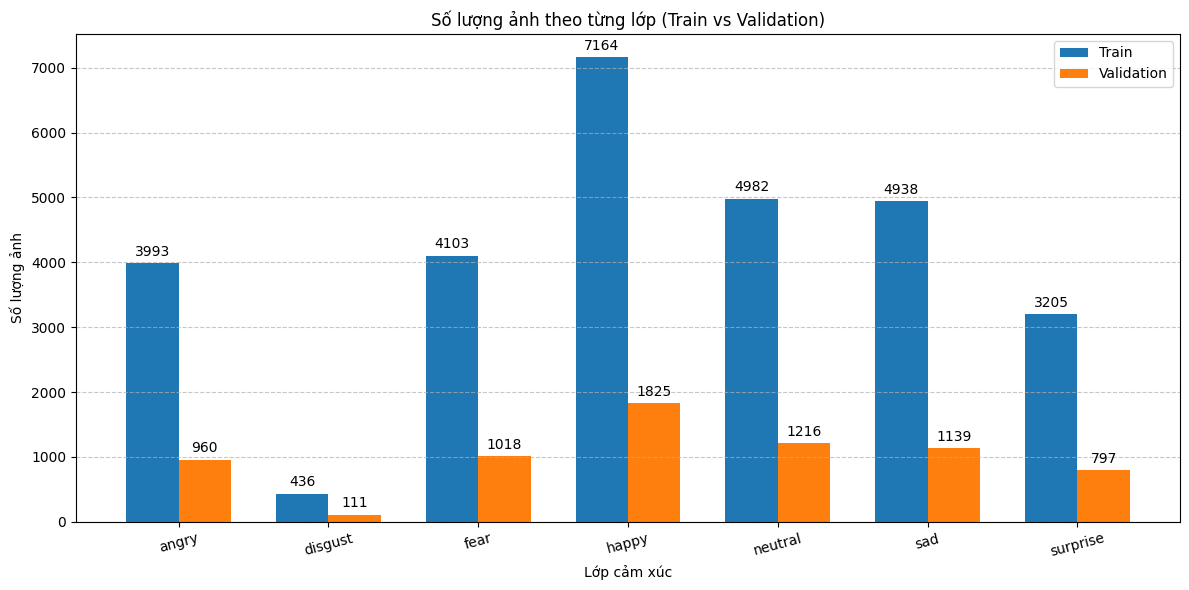

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Đường dẫn
train_dir = 'D:/DatasetDoAnCoSO/dataset_emotion/images/train'
val_dir = 'D:/DatasetDoAnCoSO/dataset_emotion/images/validation'

# Lấy danh sách lớp
classes = os.listdir(train_dir)
train_counts = []
val_counts = []

# Đếm ảnh
for cls in classes:
    train_path = os.path.join(train_dir, cls)
    val_path = os.path.join(val_dir, cls)

    train_count = len(os.listdir(train_path)) if os.path.exists(train_path) else 0
    val_count = len(os.listdir(val_path)) if os.path.exists(val_path) else 0

    train_counts.append(train_count)
    val_counts.append(val_count)

# Vẽ biểu đồ
x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, train_counts, width, label='Train')
rects2 = ax.bar(x + width/2, val_counts, width, label='Validation')

ax.set_ylabel('Số lượng ảnh')
ax.set_xlabel('Lớp cảm xúc')
ax.set_title('Số lượng ảnh theo từng lớp (Train vs Validation)')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=15)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Hiển thị số lượng trên đầu mỗi cột
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 điểm pixel lên trên
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


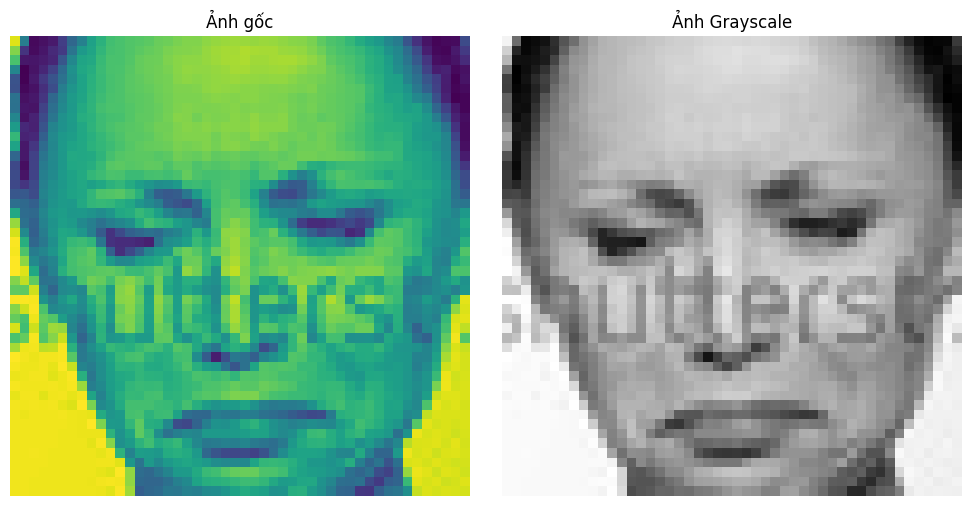

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import random
import os

# Chọn 1 lớp ngẫu nhiên từ tập train
train_dir = 'D:/DatasetDoAnCoSO/dataset_emotion/images/train'
classes = os.listdir(train_dir)
selected_class = random.choice(classes)

# Chọn 1 ảnh ngẫu nhiên trong lớp đó
image_files = os.listdir(os.path.join(train_dir, selected_class))
selected_image_path = os.path.join(train_dir, selected_class, random.choice(image_files))

# Đọc ảnh gốc
original_img = Image.open(selected_image_path)
# Chuyển sang Grayscale
gray_img = original_img.convert('L')

# Hiển thị cả 2 ảnh
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_img)
axes[0].set_title("Ảnh gốc")
axes[0].axis('off')

axes[1].imshow(gray_img, cmap='gray')
axes[1].set_title("Ảnh Grayscale")
axes[1].axis('off')

plt.tight_layout()
plt.show()


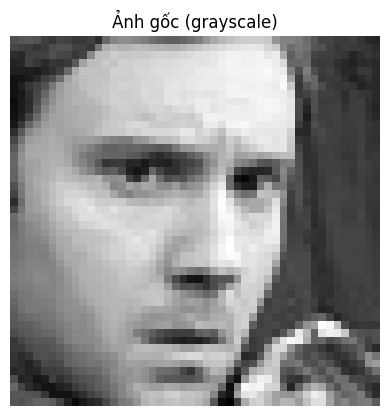

Ảnh trước khi flatten:
Hình dạng: (48, 48)
[[ 72  78  81 ...  52  43  40]
 [ 65  62  59 ...  55  52  45]
 [ 47  42  60 ...  47  54  49]
 ...
 [ 91  65  46 ...  74  54  43]
 [ 76  80  76 ... 108  69  46]
 [ 77  74  81 ... 105 108  82]]

Ảnh sau khi flatten:
Hình dạng: (2304,)
[ 72  78  81 ... 105 108  82]


In [22]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

# Lấy một ảnh mẫu, chuyển sang grayscale
sample_class = classes[0]
sample_path = os.path.join(train_dir, sample_class)
sample_image_file = os.listdir(sample_path)[0]
image_path = os.path.join(sample_path, sample_image_file)

# Đọc và chuyển sang grayscale
img = Image.open(image_path).convert('L')  # Grayscale
img_array = np.array(img)

# Hiển thị ảnh gốc grayscale
plt.imshow(img_array, cmap='gray')
plt.title("Ảnh gốc (grayscale)")
plt.axis('off')
plt.show()

# Trước khi flatten
print("Ảnh trước khi flatten:")
print(f"Hình dạng: {img_array.shape}")
print(img_array)

# Sau khi flatten
pixel_values = img_array.flatten()
print("\nẢnh sau khi flatten:")
print(f"Hình dạng: {pixel_values.shape}")
print(pixel_values)

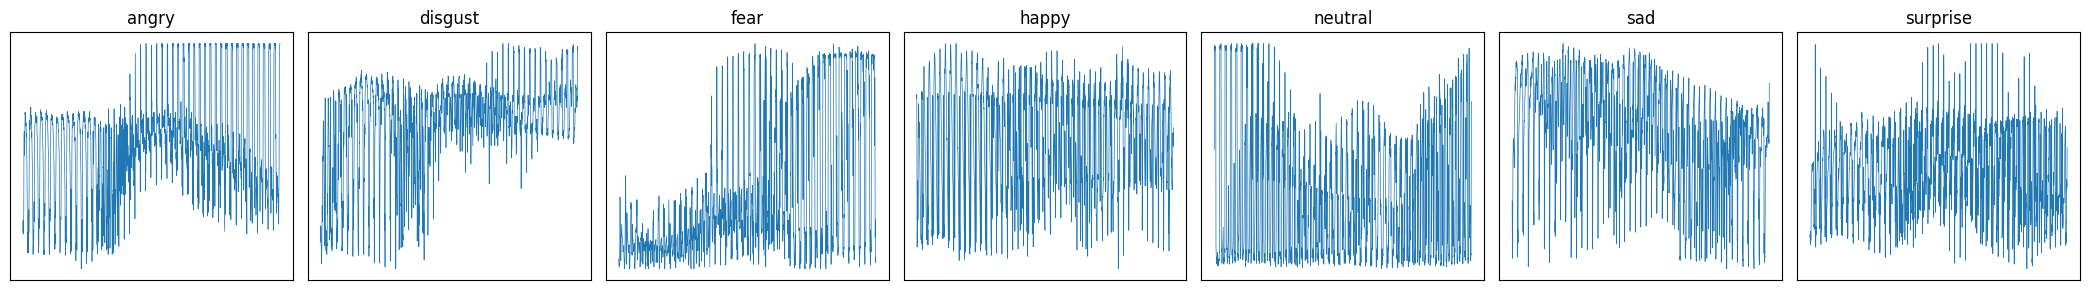

In [33]:
import os
import cv2
import matplotlib.pyplot as plt
import random

train_dir = 'D:/DatasetDoAnCoSO/dataset_emotion/images/train'
emotion_labels = os.listdir(train_dir)
selected_emotions = emotion_labels[:7]

plt.figure(figsize=(21, 3))  # rộng đủ cho 7 biểu đồ

for i, emotion in enumerate(selected_emotions):
    emotion_path = os.path.join(train_dir, emotion)
    image_names = os.listdir(emotion_path)
    chosen_image_name = random.choice(image_names)
    image_path = os.path.join(emotion_path, chosen_image_name)
    
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        continue
    
    flattened = image.flatten()
    
    plt.subplot(1, 7, i + 1)
    plt.plot(flattened, linewidth=0.5)
    plt.title(emotion)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()


In [25]:
print("Ảnh sau khi flatten (dạng vector):")
print(flattened_image)

Ảnh sau khi flatten (dạng vector):
[89 87 90 ... 15 12 20]


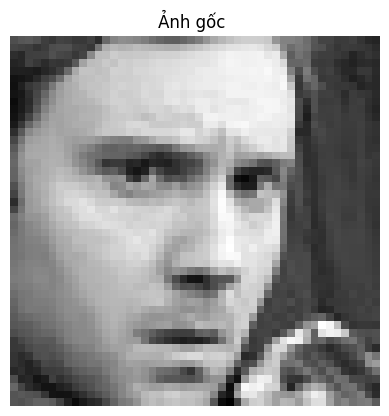

Ảnh trước khi flatten:
Hình dạng: (48, 48)
[[ 72  78  81 ...  52  43  40]
 [ 65  62  59 ...  55  52  45]
 [ 47  42  60 ...  47  54  49]
 ...
 [ 91  65  46 ...  74  54  43]
 [ 76  80  76 ... 108  69  46]
 [ 77  74  81 ... 105 108  82]]

Ảnh sau khi flatten:
Hình dạng: (2304,)
[ 72  78  81 ... 105 108  82]


In [19]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

# Lấy một ảnh mẫu, chuyển sang grayscale
sample_class = classes[0]
sample_path = os.path.join(train_dir, sample_class)
sample_image_file = os.listdir(sample_path)[0]
image_path = os.path.join(sample_path, sample_image_file)

# Hiển thị ảnh gốc grayscale
plt.imshow(img_array, cmap='gray')
plt.title("Ảnh gốc ")
plt.axis('off')
plt.show()

# Trước khi flatten
print("Ảnh trước khi flatten:")
print(f"Hình dạng: {img_array.shape}")
print(img_array)

# Sau khi flatten
pixel_values = img_array.flatten()
print("\nẢnh sau khi flatten:")
print(f"Hình dạng: {pixel_values.shape}")
print(pixel_values)


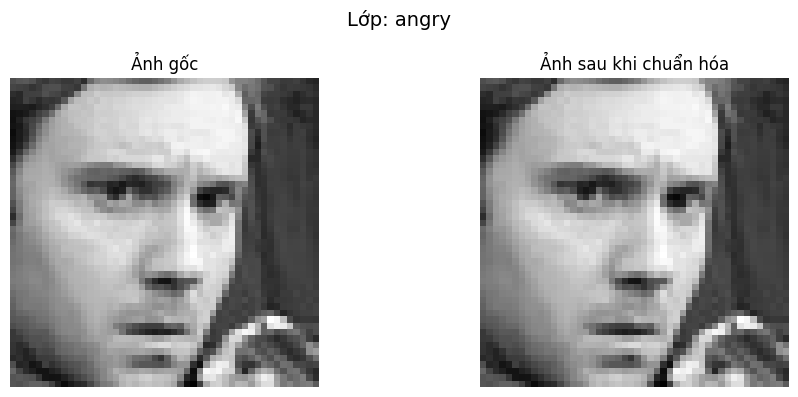

▶ Giá trị pixel ảnh gốc (0-255):
[[ 72  78  81  75  59  54  63  61  55  55]
 [ 65  62  59  52  58  71  73  73  62  60]
 [ 47  42  60  61  62  73  66  64  55  64]
 [ 40  43  62  54  45  54  52  56  80 138]
 [ 35  36  35  32  41  48  60  94 142 162]]

▶ Giá trị pixel sau chuẩn hóa (0.0 , 1.0):
[[0.28235295 0.30588236 0.31764707 0.29411766 0.23137255 0.21176471
  0.24705882 0.23921569 0.21568628 0.21568628]
 [0.25490198 0.24313726 0.23137255 0.20392157 0.22745098 0.2784314
  0.28627452 0.28627452 0.24313726 0.23529412]
 [0.18431373 0.16470589 0.23529412 0.23921569 0.24313726 0.28627452
  0.25882354 0.2509804  0.21568628 0.2509804 ]
 [0.15686275 0.16862746 0.24313726 0.21176471 0.1764706  0.21176471
  0.20392157 0.21960784 0.3137255  0.5411765 ]
 [0.13725491 0.14117648 0.13725491 0.1254902  0.16078432 0.1882353
  0.23529412 0.36862746 0.5568628  0.63529414]]


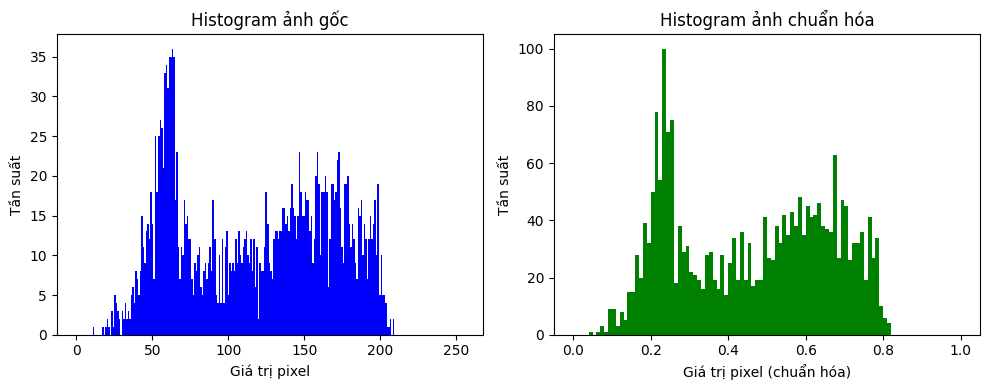

In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# --- Bước 1: Lấy một ảnh bất kỳ từ tập train ---
train_dir = 'D:/DatasetDoAnCoSO/Dataset_FER_2013/images/train'
classes = os.listdir(train_dir)
classes.sort()

# Chọn ảnh đầu tiên của lớp đầu tiên có ảnh
for cls in classes:
    cls_path = os.path.join(train_dir, cls)
    if os.path.isdir(cls_path) and len(os.listdir(cls_path)) > 0:
        img_path = os.path.join(cls_path, os.listdir(cls_path)[0])
        break

# --- Bước 2: Đọc và chuyển ảnh về grayscale ---
img = Image.open(img_path).convert('L')  # Ảnh grayscale
img_array = np.array(img, dtype=np.uint8)  # [0, 255]

# --- Bước 3: Chuẩn hóa ảnh ---
normalized_img = img_array.astype(np.float32) / 255.0  # [0.0, 1.0]

# --- Bước 4: Hiển thị ảnh gốc và ảnh chuẩn hóa ---
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_array, cmap='gray')
plt.title('Ảnh gốc')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(normalized_img, cmap='gray')
plt.title('Ảnh sau khi chuẩn hóa')
plt.axis('off')

plt.suptitle(f"Lớp: {cls}", fontsize=14)
plt.tight_layout()
plt.show()

# --- Bước 5: In ra một phần giá trị pixel ---
print("▶ Giá trị pixel ảnh gốc (0-255):")
print(img_array[:5, :10])  # In 5 dòng đầu, 10 cột đầu

print("\n▶ Giá trị pixel sau chuẩn hóa (0.0 , 1.0):")
print(normalized_img[:5, :10])

# --- Bước 6: Vẽ histogram để so sánh ---
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(img_array.ravel(), bins=256, range=(0, 255), color='blue')
plt.title("Histogram ảnh gốc")
plt.xlabel("Giá trị pixel")
plt.ylabel("Tần suất")

plt.subplot(1, 2, 2)
plt.hist(normalized_img.ravel(), bins=100, range=(0.0, 1.0), color='green')
plt.title("Histogram ảnh chuẩn hóa")
plt.xlabel("Giá trị pixel (chuẩn hóa)")
plt.ylabel("Tần suất")

plt.tight_layout()
plt.show()


▶ Chuỗi pixel gốc:
34 87 123 255 0 45 200 56 78 90 100 120 130 150 160 170 180 190 210 230 240 250

▶ Mảng pixel trước chuẩn hóa (0-255):
[ 34.  87. 123. 255.   0.  45. 200.  56.  78.  90. 100. 120. 130. 150.
 160. 170. 180. 190. 210. 230. 240. 250.]

▶ Mảng pixel sau chuẩn hóa (0.0 - 1.0):
[0.13333334 0.34117648 0.48235294 1.         0.         0.1764706
 0.78431374 0.21960784 0.30588236 0.3529412  0.39215687 0.47058824
 0.50980395 0.5882353  0.627451   0.6666667  0.7058824  0.74509805
 0.8235294  0.9019608  0.9411765  0.98039216]


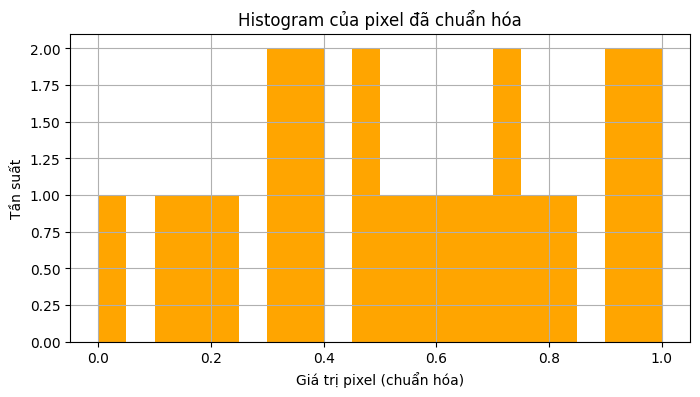

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# --- Bước 1: Giả lập một chuỗi pixel như trong file CSV ---
pixel_string = '34 87 123 255 0 45 200 56 78 90 100 120 130 150 160 170 180 190 210 230 240 250'
print("▶ Chuỗi pixel gốc:")
print(pixel_string)

# --- Bước 2: Chuyển chuỗi pixel thành mảng số ---
pixel_array = np.array(pixel_string.split(), dtype=np.float32)
print("\n▶ Mảng pixel trước chuẩn hóa (0-255):")
print(pixel_array)

# --- Bước 3: Chuẩn hóa về [0, 1] ---
pixel_array /= 255.0
print("\n▶ Mảng pixel sau chuẩn hóa (0.0 - 1.0):")
print(pixel_array)

# --- Bước 4: Vẽ biểu đồ histogram ---
plt.figure(figsize=(8, 4))
plt.hist(pixel_array, bins=20, color='orange')
plt.title("Histogram của pixel đã chuẩn hóa")
plt.xlabel("Giá trị pixel (chuẩn hóa)")
plt.ylabel("Tần suất")
plt.grid(True)
plt.show()


In [4]:
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Đường dẫn
train_dir = 'D:/DatasetDoAnCoSO/dataset_emotion/images/train'
val_dir = 'D:/DatasetDoAnCoSO/dataset_emotion/images/validation'

# Tạo các generator
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)

# Tạo các generator cho train và validation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(56, 56),
    color_mode="grayscale",
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(56, 56),
    color_mode="grayscale",
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Lưu thông tin về generator vào file JSON
generator_info = {
    "train_generator": {
        "target_size": train_generator.target_size,
        "color_mode": train_generator.color_mode,
        "batch_size": train_generator.batch_size,
        "class_mode": train_generator.class_mode,
        "num_classes": len(train_generator.class_indices),
        "class_labels": list(train_generator.class_indices.keys())
    },
    "validation_generator": {
        "target_size": validation_generator.target_size,
        "color_mode": validation_generator.color_mode,
        "batch_size": validation_generator.batch_size,
        "class_mode": validation_generator.class_mode,
        "num_classes": len(validation_generator.class_indices),
        "class_labels": list(validation_generator.class_indices.keys())
    }
}

# Lưu vào file JSON
with open('generator_info.json', 'w') as json_file:
    json.dump(generator_info, json_file, indent=4)

print("File generator_info.json đã được tạo!")

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
File generator_info.json đã được tạo!
